In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
task1 = pd.read_csv('task1_dataset.csv')
poi = pd.read_csv('cell_POIcat.csv')

In [3]:
task1 = task1[task1['x'] != 999]

In [4]:
task1_night = task1[(task1['t'] <= 13) | (task1['t'] >= 38)]
task1_night_count = task1_night.groupby(['uid', 'x', 'y']).count().reset_index()
home_idx = task1_night_count.groupby(['uid'])['t'].idxmax()
home_locations = task1_night_count.loc[home_idx,:]
home_locations = home_locations[home_locations['x'] < 250].reset_index(drop=True)

In [5]:
task1_day = task1[(task1['t'] > 13) & (task1['t'] < 38)]
task1_day_count = task1_day.groupby(['uid', 'x', 'y']).count().reset_index()
work_idx = task1_day_count.groupby(['uid'])['t'].idxmax()
work_locations = task1_day_count.loc[work_idx,:]
work_locations = work_locations[work_locations['x'] < 250].reset_index(drop=True)

In [13]:
work_merged = task1.merge(work_locations, on='uid', how='inner')

In [18]:
at_work = work_merged[(work_merged['x_x'] == work_merged['x_y']) & (work_merged['y_x'] == work_merged['y_y'])][['uid','d_x','t_x','x_x','y_x']].reset_index(drop=True)

In [33]:
grouped_at_work = at_work.groupby(['uid','d_x'])
work_start = grouped_at_work['t_x'].min().reset_index()
work_end = grouped_at_work['t_x'].max().reset_index()

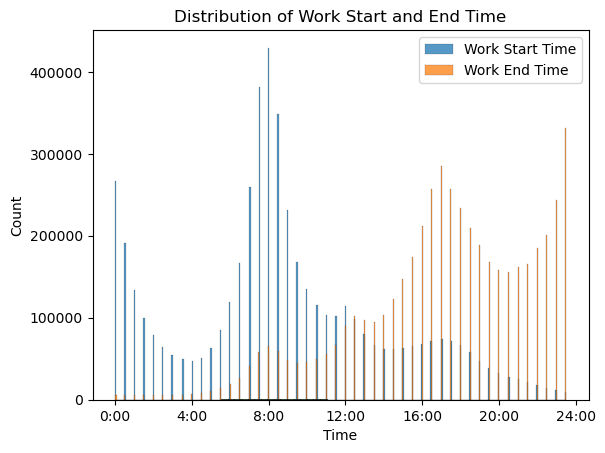

In [52]:
fig, ax = plt.subplots()
sns.histplot(work_start['t_x'], ax=ax, label='Work Start Time')
sns.histplot(work_end['t_x'], ax=ax, label='Work End Time')
ax.set(xticks=np.arange(0,52,8), xticklabels=[str(int(i/2))+':00' for i in np.arange(0,52,8)],
       xlabel='Time',
       title='Distribution of Work Start and End Time')
plt.legend()

In [53]:
work_start_filtered = work_start[(work_start['t_x'] >= 8) & (work_start['t_x'] <= 26)]['t_x'].to_numpy()
work_end_filtered = work_start[(work_start['t_x'] >= 26) & (work_start['t_x'] <= 42)]['t_x'].to_numpy()

Text(0.5, 1.0, 'Adjusted Work Start and End Distributions')

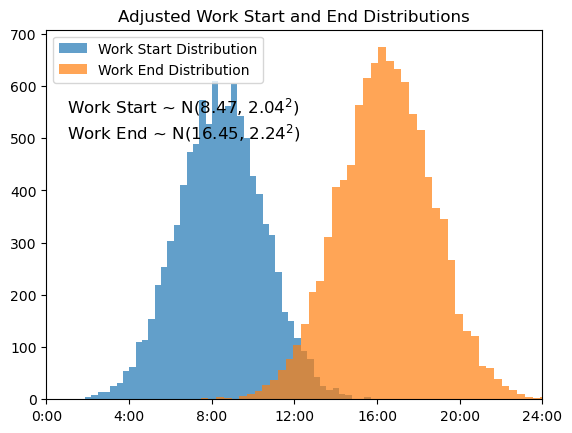

In [82]:
mu_ws, std_ws = np.mean(work_start_filtered), np.std(work_start_filtered)
work_start_sample = np.random.normal(mu_ws, std_ws, 10000)
mu_wd, std_wd = np.mean(work_end_filtered), np.std(work_end_filtered)
work_end_sample = np.random.normal(mu_wd, std_wd, 10000)

fig, ax = plt.subplots()
ax.hist(work_start_sample, bins=48, label='Work Start Distribution', alpha=0.7)
ax.hist(work_end_sample, bins=48, label='Work End Distribution', alpha=0.7)

plt.legend()

plt.text(x=2, y=550, s=f"Work Start ~ N({round(mu_ws/2,2)}, ${round(std_ws/2,2)}^{2}$)", fontsize=12)
plt.text(x=2, y=500, s=f"Work End ~ N({round(mu_wd/2,2)}, ${round(std_wd/2,2)}^{2}$)", fontsize=12)
ax.set(xlim=(0,48), xticks=np.arange(0,52,8), xticklabels=[str(int(i/2))+':00' for i in np.arange(0,52,8)])

plt.title('Adjusted Work Start and End Distributions')

In [144]:

import skmob
import warnings
import importlib
import src.skmob
importlib.reload(src.skmob)
from src.skmob.models.markov_diary_generator import MarkovDiaryGenerator
warnings.filterwarnings("ignore")

In [96]:
user2 = task1[task1['uid'] == 2]

In [130]:
user2['datetime'] = pd.to_datetime(user2['d'] * 24 * 60 * 60 + user2['t'] * 30 * 60, unit='s')
user2['cluster_id'] = [str(x) + '_' + str(y) for x, y in zip(user2['x'], user2['y'])]
traj_df = skmob.TrajDataFrame(user2[['uid','cluster_id','datetime']], datetime='datetime', user_id='user')
traj_df

,uid,cluster_id,datetime
3853,2,150_120,1970-01-01 14:30:00
3854,2,149_124,1970-01-01 15:00:00
3855,2,146_123,1970-01-01 18:00:00
3856,2,149_121,1970-01-01 19:00:00
3857,2,143_118,1970-01-02 12:00:00
...,...,...,...
4892,2,152_127,1970-03-16 14:30:00
4893,2,152_127,1970-03-16 15:00:00
4894,2,152_126,1970-03-16 15:30:00
4895,2,152_127,1970-03-16 17:30:00


In [145]:
mdg = MarkovDiaryGenerator()
mdg._create_time_series(traj_df, lid='cluster_id')


(datetime
 1970-01-01 14:00:00    24
 1970-01-01 15:00:00    10
 1970-01-01 16:00:00    10
 1970-01-01 17:00:00    10
 1970-01-01 18:00:00    46
                        ..
 1970-03-16 14:00:00     2
 1970-03-16 15:00:00     1
 1970-03-16 16:00:00     1
 1970-03-16 17:00:00     2
 1970-03-16 18:00:00     3
 Freq: H, Length: 1781, dtype: int64,
 14)

<bound method MarkovDiaryGenerator._create_time_series of <src.skmob.models.markov_diary_generator.MarkovDiaryGenerator object at 0x7fb6e95c5dc0>>